In [130]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [131]:
path = '/content/drive/MyDrive/새싹2기/python_DA/data/'

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install koreanize_matplotlib
import koreanize_matplotlib

In [133]:
users = pd.read_csv(path + 'hongdangmoo_users.csv')
events = pd.read_csv(path + 'hongdangmoo_events.csv')
activity = pd.read_csv(path + 'hongdangmoo_activity.csv')

In [134]:
users.head()

,user_id,signup_date,signup_ts,acquisition_channel,first_action,engagement_factor
0,user_000000,2025-01-01,2025-01-01 18:50:00,자연유입,동네생활,0.816635
1,user_000001,2025-01-01,2025-01-01 01:27:00,광고,중고거래,0.975171
2,user_000002,2025-01-01,2025-01-01 02:10:00,광고,비즈니스프로필,0.906105
3,user_000003,2025-01-01,2025-01-01 20:15:00,자연유입,동네생활,1.108512
4,user_000004,2025-01-01,2025-01-01 22:17:00,추천,동네생활,1.163289


In [135]:
events.head()

,user_id,event_time,event_name,event_category
0,user_000001,2025-01-01 02:38:00,signup,account
1,user_000001,2025-01-01 02:41:00,view_item,중고거래
2,user_000002,2025-01-01 04:22:00,signup,account
3,user_000002,2025-01-01 04:25:00,view_profile_tool,비즈니스프로필
4,user_000013,2025-01-01 05:45:00,signup,account


In [136]:
activity.head()

,user_id,event_time,event_name,event_category,signup_date,acquisition_channel,first_action,cohort_month,activity_month,month_period,cohort_week,activity_week,week_period
0,user_000001,2025-01-01 02:41:00,view_item,중고거래,2025-01-01,광고,중고거래,2025-01,2025-01,0,2024-12-30,2024-12-30,0
1,user_000002,2025-01-01 04:25:00,view_profile_tool,비즈니스프로필,2025-01-01,광고,비즈니스프로필,2025-01,2025-01,0,2024-12-30,2024-12-30,0
2,user_000013,2025-01-01 05:48:00,read_post,동네생활,2025-01-01,자연유입,동네생활,2025-01,2025-01,0,2024-12-30,2024-12-30,0
3,user_000008,2025-01-01 06:41:00,read_post,동네생활,2025-01-01,자연유입,동네생활,2025-01,2025-01,0,2024-12-30,2024-12-30,0
4,user_000002,2025-01-01 08:22:00,app_open,common,2025-01-01,광고,비즈니스프로필,2025-01,2025-01,0,2024-12-30,2024-12-30,0


## 📝 과제 1
- 월간 코호트 리텐션을 계산하고 heatmap을 그려보세요.
  - 분모: users_df의 코호트별 가입자 수
  - 분자: activity_df의 코호트별/경과월별 활동 사용자 수

In [137]:
users['signup_date'] = pd.to_datetime(users['signup_date'])

In [138]:
users["cohort_month"] = users["signup_date"].dt.to_period("M")
activity["cohort_month"] = pd.to_datetime(activity["cohort_month"], errors="coerce").dt.to_period("M")

In [139]:
# activity["month_period"] = pd.to_numeric(activity["month_period"], errors="coerce").astype("Int64")

In [140]:
# 코호트 크기(분모)
monthly_cohort_sizes = (
    users.assign(cohort_month=users['signup_date'].dt.to_period('M'))
    .groupby('cohort_month')['user_id']
    .nunique()
)

monthly_cohort_sizes

,user_id
cohort_month,
2025-01,499
2025-02,465
2025-03,577
2025-04,582
2025-05,527
2025-06,471


In [141]:
# 코호트별/경과월별 활동 사용자 수(분자)
monthly_counts = (
    activity[activity['month_period'] >= 0]
    .groupby(['cohort_month', 'month_period'])['user_id']
    .nunique()
    .unstack(fill_value=0)
)
monthly_counts

month_period,0,1,2,3,4
cohort_month,,,,,
2025-01,499,426,329,237,68
2025-02,463,411,308,227,57
2025-03,577,452,349,223,0
2025-04,581,459,333,0,0
2025-05,526,469,0,0,0
2025-06,471,1,0,0,0


In [142]:
max_month_period = int(activity['month_period'].max())
monthly_counts = monthly_counts.reindex(columns=range(0, max_month_period + 1), fill_value=0)

monthly_retention = monthly_counts.div(monthly_cohort_sizes, axis = 0) * 100 # monthly_counts를 monthly_cohort_sizes로 나누어 %로 변환

print(monthly_retention.round(1))

month_period      0     1     2     3     4
cohort_month                               
2025-01       100.0  85.4  65.9  47.5  13.6
2025-02        99.6  88.4  66.2  48.8  12.3
2025-03       100.0  78.3  60.5  38.6   0.0
2025-04        99.8  78.9  57.2   0.0   0.0
2025-05        99.8  89.0   0.0   0.0   0.0
2025-06       100.0   0.2   0.0   0.0   0.0


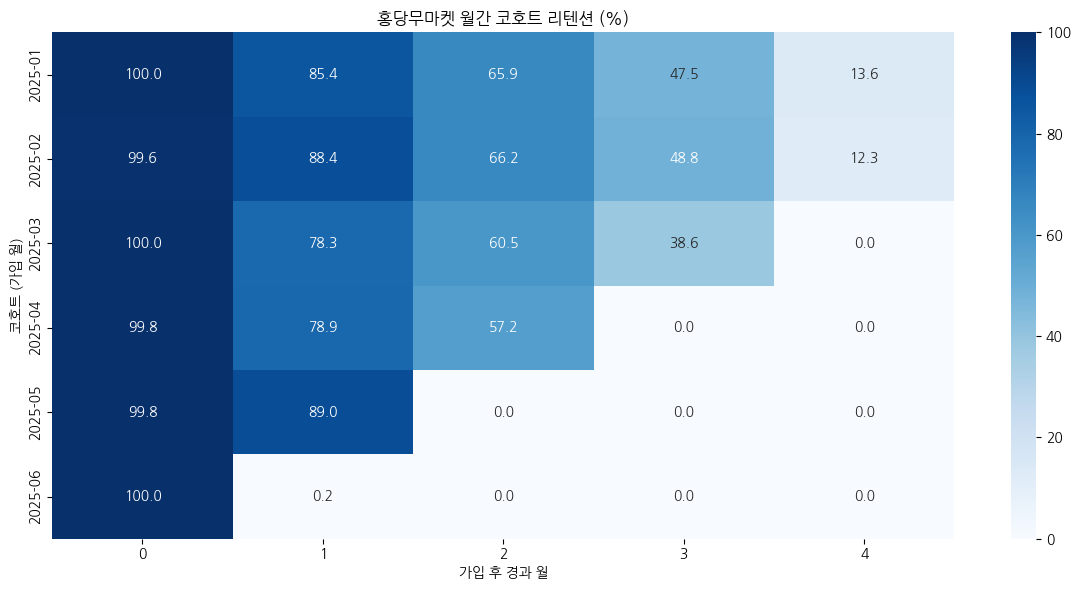

In [151]:
plt.figure(figsize=(12, 6))
sns.heatmap(monthly_retention, annot=True, fmt='.1f', cmap='Blues', vmin=0, vmax=100)
plt.title('홍당무마켓 월간 코호트 리텐션 (%)')
plt.xlabel('가입 후 경과 월')
plt.ylabel('코호트 (가입 월)')
plt.tight_layout()
plt.show()

## 📝 과제 2
- 주간 코호트 리텐션을 계산하고, 아직 관측할 수 없는 미래 주차는 NaN으로 처리하세요.
### 📌주간 리텐션 계산 기준 (중요)
- 분모: 코호트 전체 가입자 수 (users_df)
- 분자: 코호트별/경과주별 활동 사용자 수 (activity_df)
  - 미관측 주차: NaN
    - W1 / W0 방식은 100% 초과를 만들 수 있으므로 사용하지 않습니다.

In [154]:
analysis_end = pd.Timestamp("2025-06-30")
max_week = 12

# 0) 타입/기준 통일
users["signup_date"] = pd.to_datetime(users["signup_date"], errors="coerce")
activity["cohort_week"] = pd.to_datetime(activity["cohort_week"], errors="coerce")

# 주 시작일을 월요일로 고정 (둘 다 동일 규칙)
users["cohort_week"] = users["signup_date"].dt.to_period("W-MON").dt.start_time
activity["cohort_week"] = activity["cohort_week"].dt.to_period("W-MON").dt.start_time

In [155]:
# 1) 분모
weekly_cohort_sizes = users.groupby("cohort_week")["user_id"].nunique()

# 2) 분자
weekly_counts = (
    activity[activity["week_period"].between(0, max_week)]
    .groupby(["cohort_week", "week_period"])["user_id"]
    .nunique()
    .unstack(fill_value=0)
    .reindex(columns=range(0, max_week + 1), fill_value=0)
)

In [169]:
weekly_cohort_sizes

,user_id
cohort_week,
2024-12-31,98
2025-01-07,123
2025-01-14,110
2025-01-21,110
2025-01-28,116
2025-02-04,123
2025-02-11,111
2025-02-18,113
2025-02-25,110


In [165]:
# 3) 리텐션
weekly_retention = weekly_counts.div(weekly_cohort_sizes, axis=0) * 100
weekly_retention.index = pd.to_datetime(weekly_retention.index)
weekly_retention.head(10)

week_period,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort_week,,,,,,,,,,,,,
2024-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-31,112.244898,88.775510,71.428571,71.428571,61.224490,57.142857,54.081633,40.816327,38.775510,36.734694,27.551020,31.632653,30.612245
2025-01-07,91.869919,66.666667,57.723577,52.032520,48.780488,45.528455,36.585366,32.520325,26.829268,26.016260,21.951220,10.569106,16.260163
2025-01-14,101.818182,80.000000,70.909091,58.181818,60.000000,47.272727,39.090909,37.272727,30.909091,32.727273,31.818182,28.181818,27.272727
2025-01-21,102.727273,78.181818,68.181818,66.363636,49.090909,42.727273,40.000000,36.363636,31.818182,29.090909,28.181818,26.363636,24.545455
2025-01-28,105.172414,81.034483,77.586207,57.758621,48.275862,50.000000,47.413793,40.517241,37.068966,30.172414,31.896552,26.724138,27.586207
2025-02-04,95.121951,74.796748,60.162602,56.910569,52.032520,56.097561,47.967480,37.398374,34.959350,24.390244,26.016260,23.577236,23.577236
2025-02-11,99.099099,82.882883,66.666667,57.657658,55.855856,43.243243,42.342342,41.441441,34.234234,38.738739,27.927928,30.630631,29.729730
2025-02-18,95.575221,66.371681,56.637168,53.097345,45.132743,44.247788,36.283186,33.628319,27.433628,23.893805,25.663717,23.893805,23.893805


In [166]:
analysis_end

Timestamp('2025-06-30 00:00:00')

In [167]:
# 4) 관측 가능한 최대 주차 (간단 버전)
observed_max_week = pd.Series(
    (analysis_end - weekly_retention.index) // pd.Timedelta(weeks=1),
    index=weekly_retention.index
).clip(0, max_week)
observed_max_week

,cohort_week
cohort_week,
2024-12-24,12
2024-12-31,12
2025-01-07,12
2025-01-14,12
2025-01-21,12
2025-01-28,12
2025-02-04,12
2025-02-11,12
2025-02-18,12


In [ ]:

for cohort, obs_w in observed_max_week.items():
    weekly_retention.loc[cohort, weekly_retention.columns > obs_w] = np.nan

print(weekly_retention.round(1).head())

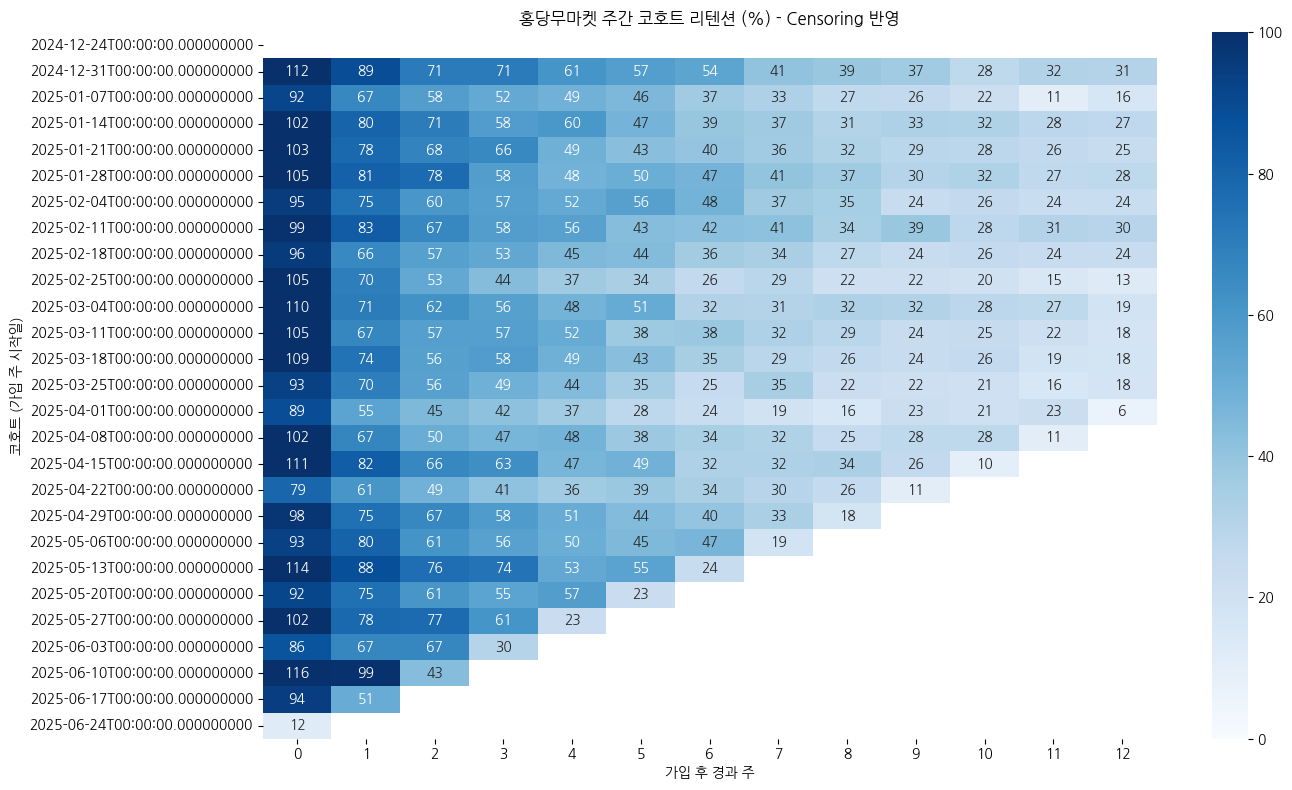

In [162]:
plt.figure(figsize=(14, 8))
sns.heatmap(weekly_retention, annot=True, fmt='.0f', cmap='Blues', vmin=0, vmax=100)
plt.title('홍당무마켓 주간 코호트 리텐션 (%) - Censoring 반영')
plt.xlabel('가입 후 경과 주')
plt.ylabel('코호트 (가입 주 시작일)')
plt.tight_layout()
plt.show()

## 📝 해석 질문
- 월간 코호트보다 주간 코호트에서 더 빨리 보이는 변화는 무엇인가요?
- 최근 코호트의 오른쪽 영역에서 0과 NaN은 각각 무엇을 의미하나요?
- 모든 코호트를 공정하게 비교하려면 W0~W몇 주까지를 보는 것이 좋을까요?

---
- 1️⃣ 주간 코호트는 초기 이탈 속도가 훨씬 선명하게 보인다
- 2️⃣ NaN은 “아직 측정 불가”, 0은 “측정했는데 생존 0
- 3️⃣ 공정 비교는 W0-W4 또는 W0-W6까지가 적절